In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

from numpy import sin, cos
import numpy as np

In [4]:
def get_hamiltonian(N, J, U, h):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    #ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    #Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    #X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]
    tuples_1 = [("XX", [i, i + 1], -J) for i in range(0, N - 1)]
    tuples_2 = [("YY", [i, i + 1], -J) for i in range(0, N - 1)]
    tuples_3 = [("ZZ", [i, i + 1], U) for i in range(0, N - 1)]
    tuples_4 = [("Z", [i], h[i]) for i in range(0, N)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*tuples_1, *tuples_2, *tuples_3, *tuples_4], num_qubits=N)
    return hamiltonian.simplify()

# Magnetization Density Plots (Fig 2g)

In [49]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

from tqdm.notebook import tqdm
from qiskit.primitives import Estimator

In [50]:
total_time = 2.5
nb_timesteps = 16
timesteps_duration = total_time/nb_timesteps

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (1/J)')

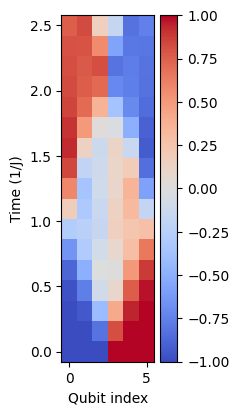

In [51]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(qc)

# Run the quantum circuit on a statevector simulator backend
#backend_sim = AerSimulator.get_backend('statevector_simulator')

def magnetization_ops(qubit):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 1.0)], num_qubits=N
    )
    return observable

estimator = Estimator()
magnetization_density=[]
for circ in tqdm(circuits):

    #outputstate = Statevector(circ)
    job = estimator.run([circ for _ in range(N)], [magnetization_ops(qubit) for qubit in range(N)])
    results = job.result()
    mags=[results.values[i] for i in range(N)]

    magnetization_density.append(mags)

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(1.5,4.5), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(nb_timesteps+1)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (1/J)')

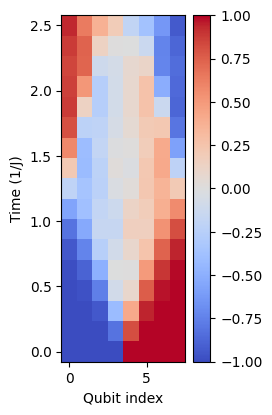

In [52]:
N = 8
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(qc)

# Run the quantum circuit on a statevector simulator backend
#backend_sim = AerSimulator.get_backend('statevector_simulator')

def magnetization_ops(qubit):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 1.0)], num_qubits=N
    )
    return observable

estimator = Estimator()
magnetization_density=[]
for circ in tqdm(circuits):

    #outputstate = Statevector(circ)
    job = estimator.run([circ for _ in range(N)], [magnetization_ops(qubit) for qubit in range(N)])
    results = job.result()
    mags=[results.values[i] for i in range(N)]

    magnetization_density.append(mags)

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(2,4.5), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(nb_timesteps+1)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (1/J)')

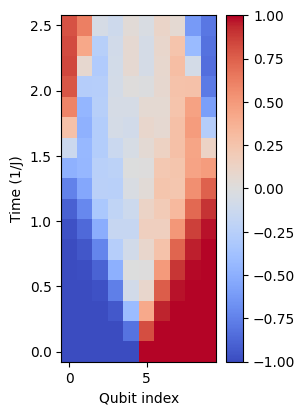

In [48]:
N = 10
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)

gate = circ.to_instruction()

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(qc)

# Run the quantum circuit on a statevector simulator backend
#backend_sim = AerSimulator.get_backend('statevector_simulator')

def magnetization_ops(qubit):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 1.0)], num_qubits=N
    )
    return observable

estimator = Estimator()
magnetization_density=[]
for circ in tqdm(circuits):

    #outputstate = Statevector(circ)
    job = estimator.run([circ for _ in range(N)], [magnetization_ops(qubit) for qubit in range(N)])
    results = job.result()
    mags=[results.values[i] for i in range(N)]

    magnetization_density.append(mags)

magnetization_density=np.array(magnetization_density)

fig = plt.figure(figsize=(2.5,4.5), facecolor='white')
im = plt.pcolormesh(np.arange(0,N,1), [timesteps_duration * i for i in range(nb_timesteps+1)], magnetization_density, cmap='coolwarm')
fig.colorbar(im)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

In [54]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)

gate = circ.to_instruction()

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
    )

magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
    )

circuits = []
for n_steps in range(nb_timesteps+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(qc)


def magnetization_ops(qubit):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 1.0)], num_qubits=N
    )
    return observable

estimator = Estimator()
magnetization_density_3=[]
magnetization_density_5=[]
for circ in tqdm(circuits):

    job = estimator.run([circ, circ], [magnetization_op_3, magnetization_op_5])
    results = job.result()

    magnetization_density_3.append(results.values[0])
    magnetization_density_5.append(results.values[1])

magnetization_density_3=np.array(magnetization_density_3)
magnetization_density_5=np.array(magnetization_density_5)

  0%|          | 0/17 [00:00<?, ?it/s]

In [59]:
total_time_long = 10
nb_timesteps_long = 64
timesteps_duration_long = total_time_long/nb_timesteps_long

N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

gate = PauliEvolutionGate(H, time=timesteps_duration_long)

st = SuzukiTrotter(order=4, reps=4)
circ = st.synthesize(gate)

gate = circ.to_instruction()

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
    )

magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
    )

circuits = []
for n_steps in range(nb_timesteps_long+1):
    qc = QuantumCircuit(N,N)
    for i in range(int(N/2)):
        qc.x(i)
    
    for _ in range(n_steps):
        qc.append(gate, [i for i in range(N)])

    circuits.append(qc)


def magnetization_ops(qubit):
    observable = SparsePauliOp.from_sparse_list(
    [("Z", [qubit], 1.0)], num_qubits=N
    )
    return observable

estimator = Estimator()
magnetization_density_5_long=[]
for circ in tqdm(circuits):

    job = estimator.run(circ, magnetization_op_5)
    results = job.result()

    magnetization_density_5_long.append(results.values[0])

magnetization_density_5_long=np.array(magnetization_density_5_long)

  0%|          | 0/65 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (1/J)')

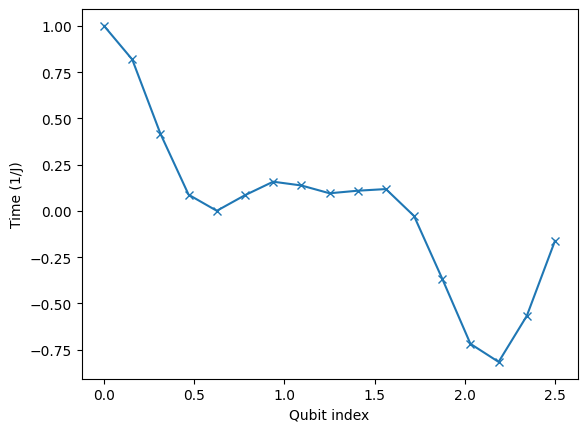

In [56]:
times = np.linspace(0, total_time, nb_timesteps + 1) 
plt.plot(times, magnetization_density_3, marker="x")
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

Text(0, 0.5, 'Time (1/J)')

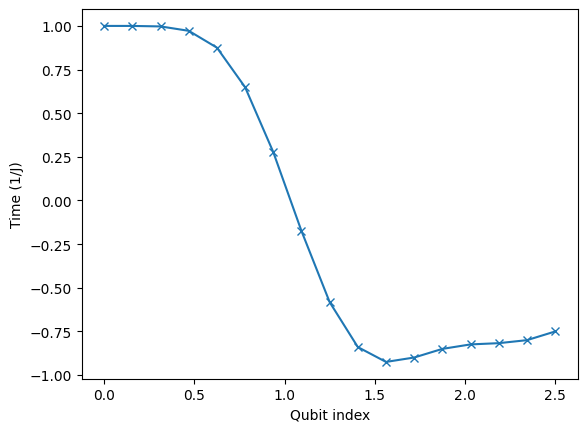

In [57]:
times = np.linspace(0, total_time, nb_timesteps + 1) 
plt.plot(times, magnetization_density_5, marker="x")
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

Text(0, 0.5, 'Time (1/J)')

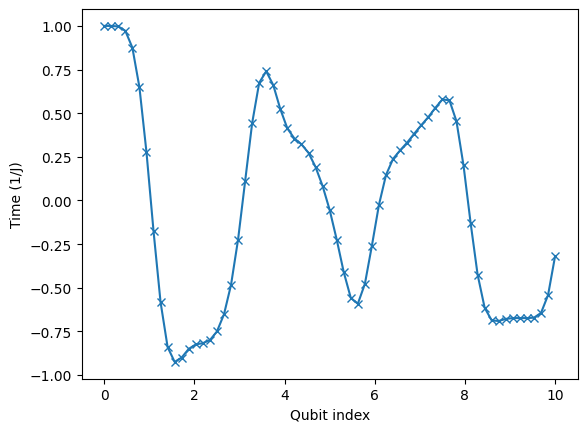

In [60]:
times_long = np.linspace(0, total_time_long, nb_timesteps_long + 1) 
plt.plot(times_long, magnetization_density_5_long, marker="x")
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

# Using deprecated Qiskit_Algorithms.time_evolvers (Suzuki Trotter)

In [99]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

In [100]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
)
magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
)

In [108]:
from qiskit_algorithms.time_evolvers import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 16
trotter = TrotterQRTE(SuzukiTrotter(order=4, reps=5), num_timesteps=num_timesteps, estimator=Estimator())

final_time = 2.5
#initial_state = Statevector.from_label("111000")
initial_state = Statevector.from_label("000111")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_3, magnetization_op_5],
)

result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

Text(0.5, 0.98, 'Observable evolution')

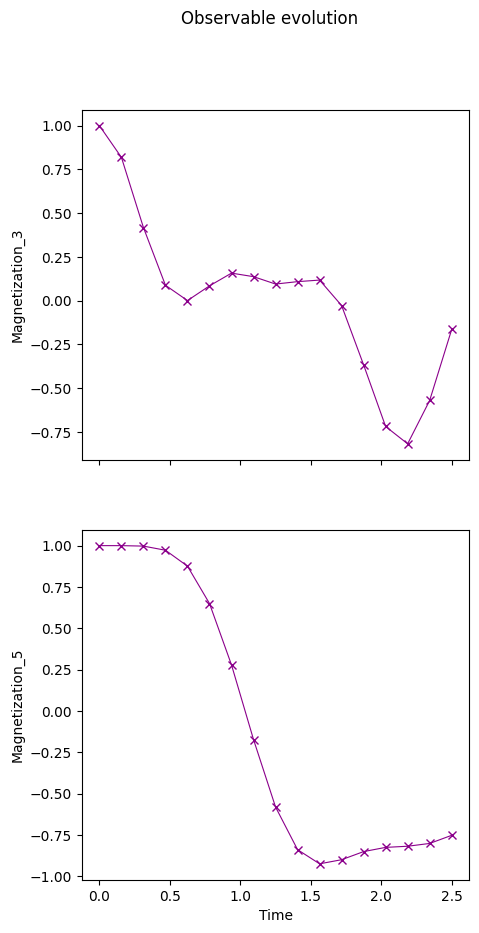

In [107]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(5,10))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Magnetization_3")
axes[1].set_ylabel("Magnetization_5")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

Text(0.5, 0.98, 'Observable evolution')

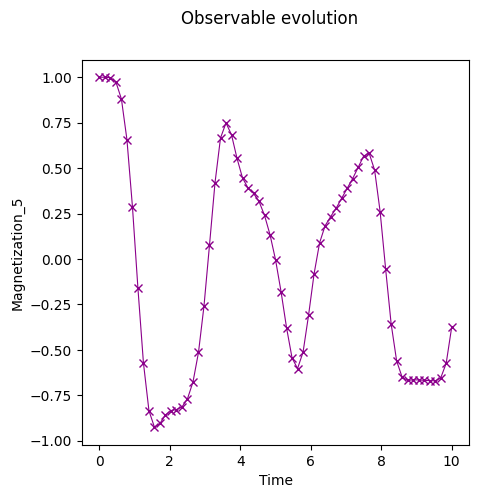

In [103]:
final_time = 10
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_5],
)
num_timesteps = 16 * 4
trotter = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=num_timesteps, estimator=Estimator())
result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

fig, axes = plt.subplots(1, sharex=True, figsize=(5,5))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes.plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.set_ylabel("Magnetization_5")
axes.set_xlabel("Time")
fig.suptitle("Observable evolution")

# Using deprecated Qiskit_Algorithms (Suzuki Trotter)

In [93]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

In [94]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
)
magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
)

In [95]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 16
trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())

final_time = 2.5
#initial_state = Statevector.from_label("111000")
initial_state = Statevector.from_label("000111")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_3, magnetization_op_5],
)

result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

Text(0.5, 0.98, 'Observable evolution')

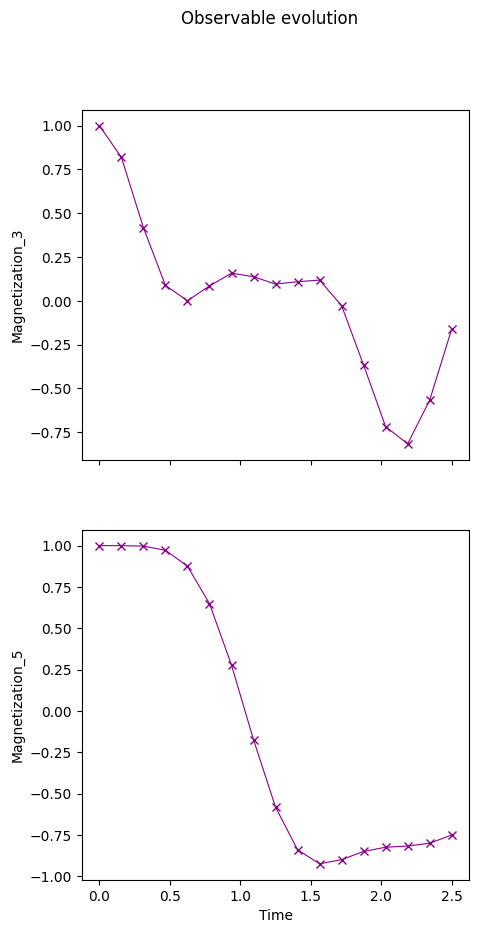

In [96]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(5,10))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Magnetization_3")
axes[1].set_ylabel("Magnetization_5")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

Text(0.5, 0.98, 'Observable evolution')

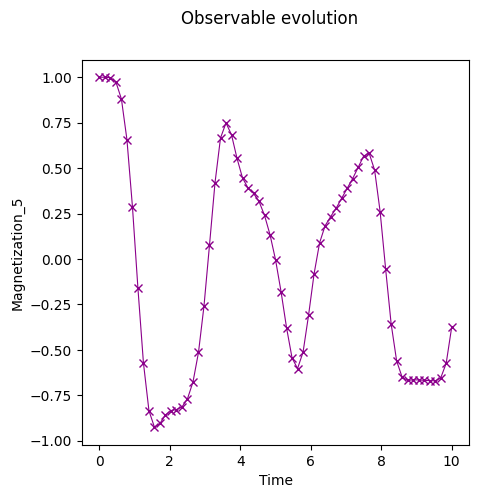

In [98]:
final_time = 10
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_5],
)
num_timesteps = 16 * 4
trotter = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=num_timesteps, estimator=Estimator())
result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

fig, axes = plt.subplots(1, sharex=True, figsize=(5,5))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes.plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.set_ylabel("Magnetization_5")
axes.set_xlabel("Time")
fig.suptitle("Observable evolution")

# Using deprecated Qiskit_Algorithms (Lie Trotter)


In [70]:
N = 6
H = get_hamiltonian(N=N, J=1, U=0, h=[0 for i in range(N)])

In [79]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

magnetization_op_3 = SparsePauliOp.from_sparse_list(
    [("Z", [3], 1.0)], num_qubits=N
)
magnetization_op_5 = SparsePauliOp.from_sparse_list(
    [("Z", [5], 1.0)], num_qubits=N
)

In [88]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 16
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

final_time = 2.5
#initial_state = Statevector.from_label("111000")
initial_state = Statevector.from_label("000111")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_3, magnetization_op_5],
)

result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

Text(0.5, 0.98, 'Observable evolution')

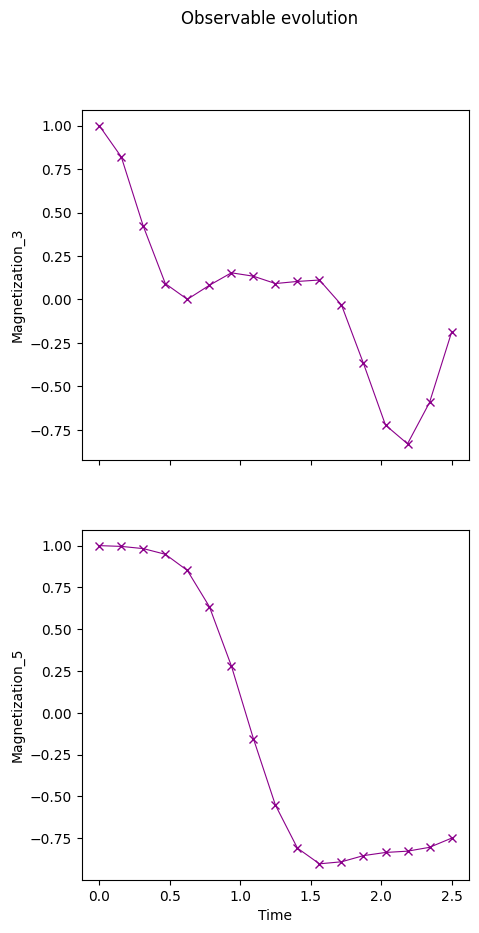

In [89]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(5,10))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Magnetization_3")
axes[1].set_ylabel("Magnetization_5")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

Text(0.5, 0.98, 'Observable evolution')

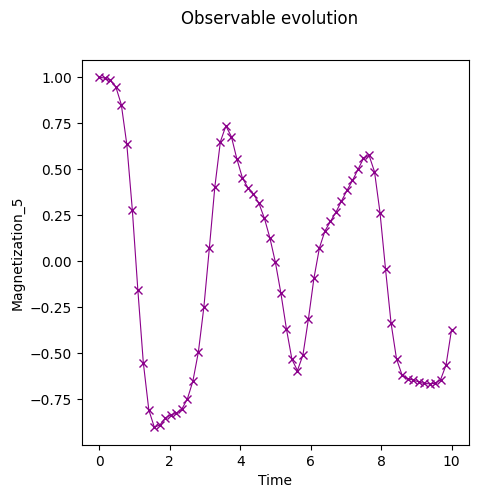

In [92]:
final_time = 10
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[magnetization_op_5],
)
num_timesteps = 16 * 4
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())
result = trotter.evolve(problem)

import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])

fig, axes = plt.subplots(1, sharex=True, figsize=(5,5))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes.plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.set_ylabel("Magnetization_5")
axes.set_xlabel("Time")
fig.suptitle("Observable evolution")

# Code from Online

In [4]:
def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [17]:
from math import pi

H = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

In [18]:
from qiskit.circuit.library import PauliEvolutionGate

gate = PauliEvolutionGate(H)

In [22]:
from qiskit.synthesis import SuzukiTrotter

st = SuzukiTrotter(order=2, reps=2)
circ = st.synthesize(gate)

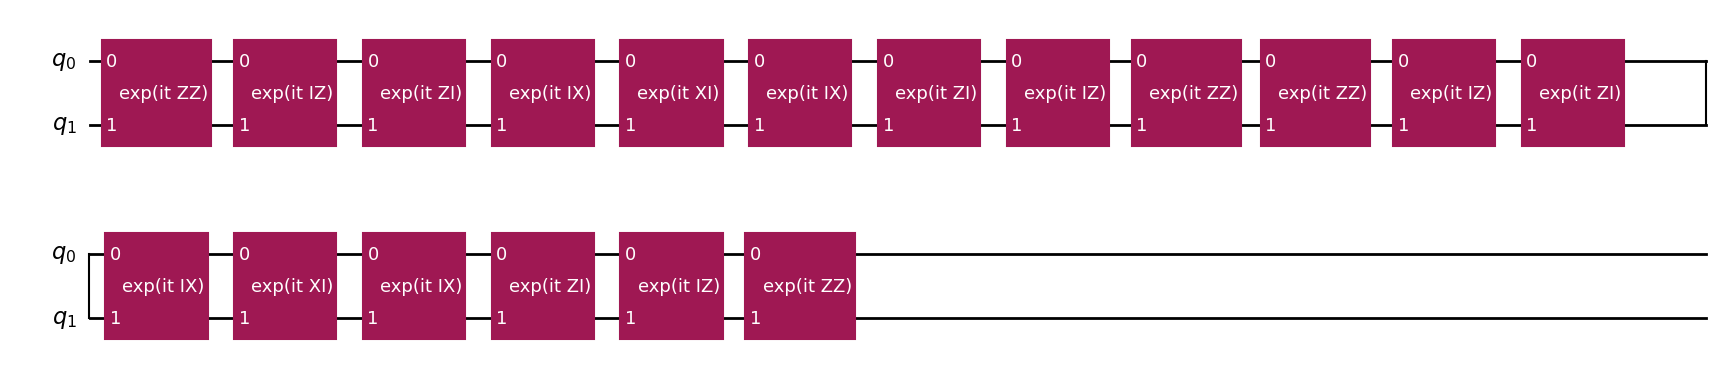

In [23]:
circ.draw('mpl')

In [7]:
%pip install qiskit_algorithms

  Obtaining dependency information for qiskit_algorithms from https://files.pythonhosted.org/packages/e0/2f/9a71fc36ff8de0188d4325399e1ad29c8fce2c2b427dae6c900003510943/qiskit_algorithms-0.3.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 7.3 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

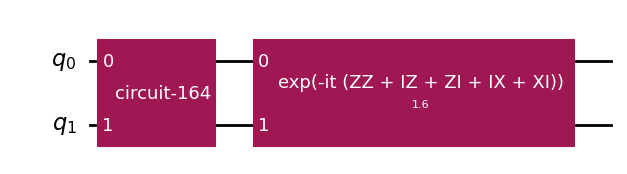

In [10]:
result.evolved_state.draw("mpl")

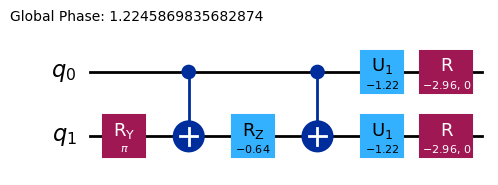

In [15]:
result.evolved_state.decompose(reps=3).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

In [16]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))
